# Problems 3/4

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

## Modeling

In [28]:
# Get data from file
df = pd.read_csv('insurance.csv')
df.drop(['sex', 'smoker', 'region'], axis=1, inplace=True)
df

,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520
...,...,...,...,...
1333,50,30.970,3,10600.54830
1334,18,31.920,0,2205.98080
1335,18,36.850,0,1629.83350
1336,21,25.800,0,2007.94500


In [29]:
# Spilt data into training and testing sets
data = df.to_numpy()
# use train mean/std everywhere
train_x = data[:int(len(data) * 0.8), :3]
train_y = data[:int(len(data) * 0.8), 3]
test_x = data[int(len(data) * 0.8):, :3]
test_y = data[int(len(data) * 0.8):, 3]
# Normalize the training and testing sets
mean_x = np.mean(train_x, axis=0)
std_x = np.std(train_x, axis=0)
mean_y = np.mean(train_y)
std_y = np.std(train_y)
train_x = (train_x - mean_x) / std_x
test_x = (test_x - mean_x) / std_x
train_y = (train_y - mean_y) / std_y
test_y = (test_y - mean_y) / std_y

In [30]:
# Build data dictionary
data_dict = {
    'N': train_x.shape[0],
    'M': test_x.shape[0],
    'K': train_x.shape[1],
    'x': train_x,
    'x_test': test_x,
    'y': train_y,
}

# Compile Stan model
program_code = open('regression.stan').read()
model = stan.build(program_code, data_dict)

Building...



Building: found in cache, done.

In [31]:
fit = model.sample(num_chains=4, num_warmup=1000, num_samples=2000)

Sampling:   0%
Sampling:   1% (100/12000)
Sampling:   2% (300/12000)
Sampling:   4% (500/12000)
Sampling:   5% (600/12000)
Sampling:   9% (1100/12000)
Sampling:  13% (1600/12000)
Sampling:  18% (2200/12000)
Sampling:  23% (2800/12000)
Sampling:  43% (5200/12000)
Sampling:  62% (7500/12000)
Sampling:  81% (9700/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 0.001919 seconds
  1000 transitions using 10 leapfrog steps per transition would take 19.19 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.001935 seconds
  1000 transitions using 10 leapfrog steps per transition would take 19.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.002438 seconds
  1000 transitions using 10 leapfrog steps per transition would take 24.38 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.002931 seconds
  1000 transitions using 10 leapf

## Analysis

In [32]:
# Posterior summary statistics
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.000,0.029,-0.053,0.058,0.000,0.000,9822.0,5711.0,1.0
beta[0],0.297,0.029,0.242,0.349,0.000,0.000,10017.0,5911.0,1.0
beta[1],0.158,0.029,0.104,0.213,0.000,0.000,9574.0,6441.0,1.0
beta[2],0.046,0.029,-0.007,0.101,0.000,0.000,9959.0,6039.0,1.0
sigma,0.936,0.021,0.899,0.974,0.000,0.000,9520.0,6336.0,1.0
...,...,...,...,...,...,...,...,...,...
y_pred[263],0.306,0.932,-1.454,2.069,0.010,0.007,8094.0,7721.0,1.0
y_pred[264],-0.456,0.938,-2.203,1.315,0.011,0.007,7859.0,7832.0,1.0
y_pred[265],-0.332,0.929,-2.023,1.420,0.010,0.007,8185.0,8079.0,1.0
y_pred[266],-0.572,0.946,-2.380,1.142,0.011,0.007,7784.0,7534.0,1.0


**Result:** $\beta_0$, which corresponds to `age`, is the largest of our 3 predictors and is therefore the best predictor of insurance charges.

**Convergence:** The resulting `r_hat` score for all parameters is 1.0, which indicates convergence.

/home/carror/miniconda3/envs/cognitive/lib/python3.12/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (273), generating only 20 plots
  warnings.warn(


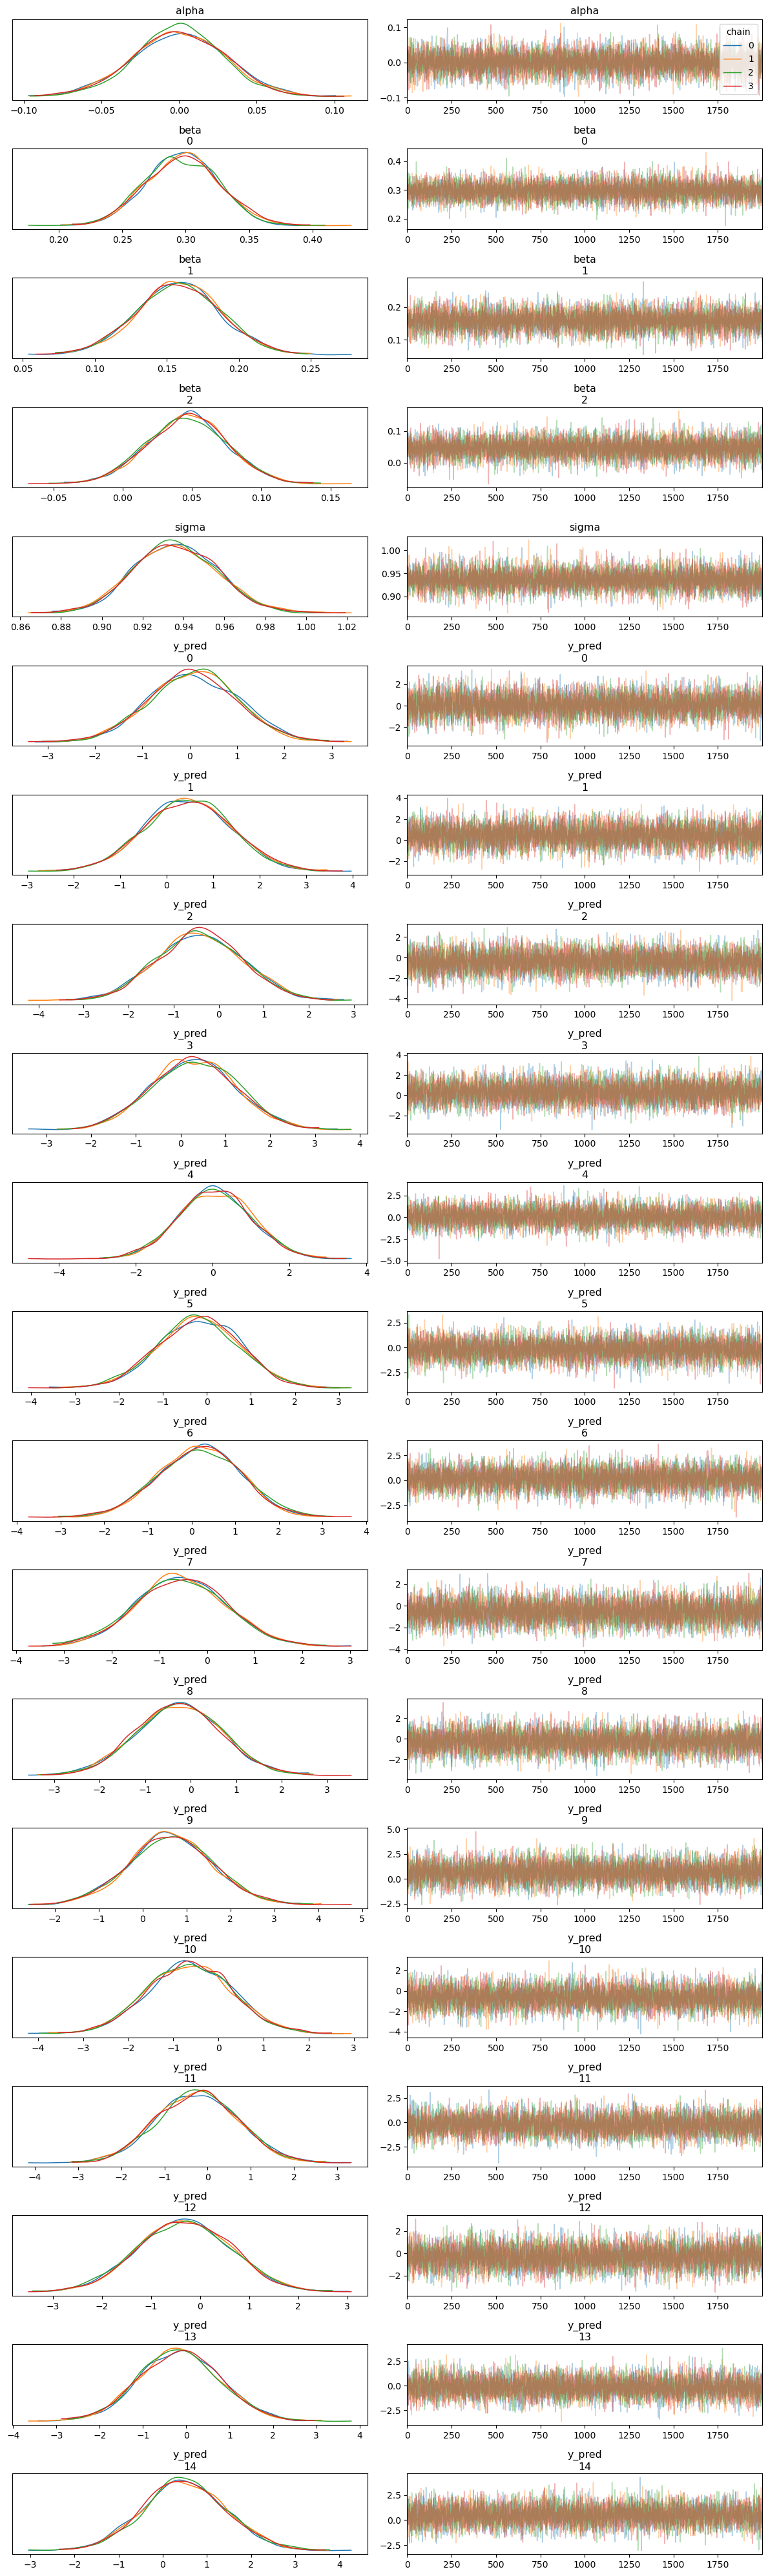

In [33]:
# Traceplots 
f = az.plot_trace(fit, compact=False, legend=True)
plt.tight_layout()

We see here that our chains each give similar results. We also see that our trace plots have well-mixed, random patterns. This indicates convergence.

In [34]:
rmse = math.sqrt(np.mean((fit["y_pred"].mean(axis=1) - test_y) ** 2))
rmse

0.9855997162163976

### RMSE Analysis

1. The obtained value is $RMSE \approx 0.99$. This indicates a weak model in terms of predictiveness; the data was normalized to have a mean of $0$ and a standard deviation of $1$, so we are doing very slightly better than if we just guessed the mean for each predicted value.
2. Each value for the test set receives $4$ chains $*$ $2000$ samples $=8000$ total predictions. The test set has $268$ values. By reducing all of these to a single number, we lose uncertainty information, such as variance, and the ability to analyze how each sample varies.
3. Instead of calculating one overall $RMSE$, we could get the $RMSE$ of each sample:
$RMSE_s = \sqrt{\frac{1}{M} \sum_{m=1}^M(\hat{y}_m^s - y_m)^2}$


In [ ]:
rmse_array = np.zeros(fit["y_pred"].shape[1])
for s in range(fit["y_pred"].shape[1]):
    rmse_array[s] = math.sqrt(np.mean((fit["y_pred"][:, s] - test_y) ** 2))
rmse_array

array([1.39232398, 1.38335606, 1.34594791, ..., 1.35438055, 1.38178833,
       1.38044107])

In [88]:
rmse_array.mean(), rmse_array.std()

(1.359781042925135, 0.051811954629301146)